In [11]:
from __future__ import print_function
import argparse
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable


In [4]:
x = Variable(torch.Tensor([[0,1],[1,-1]]), requires_grad=True)
y = torch.sum(torch.pow(x,2))

y.backward()

print(x.size())

# print(x.grad)

# x += 0.03*torch.sign(x.grad) + x.grad
# y = torch.sum(torch.pow(x_, 2))
# y.backward()

# print(x_.grad)

# x_ = Variable(x.var + x.grad, requires_grad=False)

torch.Size([2, 2])


In [12]:
# Training settings
parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=3, metavar='N',
                    help='number of epochs to train (default: 3)')
parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                    help='learning rate (default: 0.01)')
parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                    help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=True,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
args, unparsed = parser.parse_known_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()
args.epochs = 3
args.lr = 0.05
# args.batch_size = 256
# args.momentum = 0.8

print(args)

torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

Namespace(batch_size=64, cuda=False, epochs=3, log_interval=10, lr=0.05, momentum=0.5, no_cuda=True, seed=1, test_batch_size=1000)


In [13]:
# Import data
kwargs = {'num_workers': 4, 'pin_memory': True} if args.cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args.batch_size, shuffle=True, **kwargs)

In [14]:
#Define the model
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, (5, 5), padding=2)
        self.conv2 = nn.Conv2d(6, 16, (5, 5))
        self.fc1 = nn.Linear(16 * 5 * 5, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x)

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

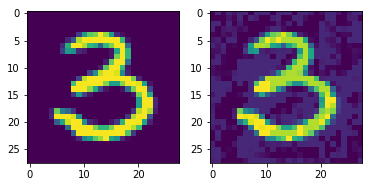

In [53]:
def perturb(model, x_nat, y):
    """ Takes an input batch and adds a small perturbation """
    epsilon = 0.2 # Maximum strength of the perturbation
    a = 0.01 # maximum change to the image
    k = 40
    x = Variable(x_nat + 2*epsilon*(torch.rand(x_nat.size())-0.5), requires_grad=True)
    y = Variable(y)
    for _ in range(k):
        y_ = model(x)
        loss = F.cross_entropy(y_, y)
        loss.backward()
        x = x + a*torch.sign(x.grad)
        x = torch.min(torch.max(x.data, x_nat-epsilon), x_nat+epsilon)
#         x = torch.clamp(x, -mean/std, (image_range-mean)/std)
        x = Variable(x, requires_grad=True)
    return x.detach(), y

import matplotlib.pyplot as plt

for batch_idx, (data, target) in enumerate(train_loader):
    data_p, target = perturb(model, data, target)
#     print(data[0,0,:,:])
#     print(data_p[0,0,:,:])
#     print(data_p[0,0,:,:]-Variable(data[0,0,:,:]))
#     break
    plt.subplot(1,2,1)
    plt.imshow(data[0,0,:,:].numpy()*0.3081+0.1307)
    plt.subplot(1,2,2)
    plt.imshow(data_p[0,0,:,:].data.numpy()*0.3081+0.1307)
    plt.show()
    break
    

In [16]:
#Train function
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            sys.stdout.write('\r Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.data[0]))

In [17]:
#Test Function
def test(epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        data, target = perturb(model, data, target)
#         data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target).data[0]
        pred = output.data.max(1)[1]  # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss = test_loss
    test_loss /= len(test_loader)  # loss function already averages over batch size
    acc = correct/len(test_loader.dataset)
    print("\n### TEST ###")
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * acc))
    return acc


In [ ]:
model = LeNet()
print(model)

if args.cuda:
    model.cuda()

# optimizer = optim.SGD(model.parameters(), lr=args.lr)
# optimizer = optim.Adam(model.parameters(), lr=args.lr)
optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

accuracy = [0.0]*args.epochs

for epoch in range(1, args.epochs + 1):
    train(epoch)
    accuracy[epoch-1] = test(epoch)


LeNet (
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear (400 -> 500)
  (fc2): Linear (500 -> 10)
)
 Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.242865

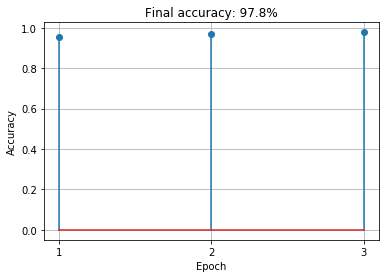

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

f = plt.figure()
p = plt.stem(range(1, args.epochs+1), accuracy)
plt.xticks(range(1, args.epochs+1))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid('on')
plt.title('Final accuracy: {}%'.format(accuracy[-1]*100))
# f.savefig('results-4.pdf', bbox_inches='tight')